In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_time_domain(t1, v1, t2, v2, label1, label2):
    """Grafica ambas señales en el dominio del tiempo."""
    plt.figure(figsize=(12, 5))
    plt.plot(t1, v1, 'b-', label=label1, alpha=0.7)
    plt.plot(t2, v2, 'r-', label=label2, alpha=0.7)
    plt.xlabel('Tiempo')
    plt.ylabel('Valor')
    plt.title('Comparación en el Dominio del Tiempo')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

def load_csv(filename):
    """Carga un archivo CSV y devuelve timestamps y valores."""
    df = pd.read_csv(filename)
    timestamps = pd.to_datetime(df['Timestamp'])  # Convierte a datetime
    values = df['Value'].astype(float)           # Asegura que sean floats
    return timestamps, values

def media_movil(datos, ventana):
    """
    Aplica un filtro de media móvil sobre los datos.

    Parámetros:
        datos (list o np.array): lista de valores a filtrar
        ventana (int): tamaño de la ventana del filtro (debe ser impar idealmente)

    Retorna:
        np.array: datos filtrados
    """
    datos = np.array(datos)
    if ventana < 1:
        raise ValueError("El tamaño de la ventana debe ser mayor a 0.")
    if ventana > len(datos):
        raise ValueError("La ventana no puede ser mayor al tamaño del array.")

    # np.convolve con modo 'valid' para evitar valores incompletos
    kernel = np.ones(ventana) / ventana
    filtrado = np.convolve(datos, kernel, mode='valid')

    # Opcional: rellenar bordes para mantener tamaño igual
    bordes = (len(datos) - len(filtrado)) // 2
    resultado = np.concatenate([
        np.full(bordes, filtrado[0]),
        filtrado,
        np.full(len(datos) - len(filtrado) - bordes, filtrado[-1])
    ])

    return resultado

# file1 = 'led_raw_samples.csv'  # Primer archivo CSV
# file2 = 'led_samples_filter.csv'  # Segundo archivo CSV
file1 = 'led_fusion_raw_samples.csv'  # Segundo archivo CSV
file2 = 'led_fusion_filter_samples.csv'  # Segundo archivo CSV

t, raw_samples = load_csv(file1)

_ , filtered_samples = load_csv(file2)
sample_rate = 800  # Tasa de muestreo en Hz (ajusta según tus datos)

# Pasar de timestamps a milisegundos
t = (t - t.min()).dt.total_seconds() * 1000 * 1000 * 1.3 #
print(t)

0       0.0000
1       0.0013
2       0.0026
3       0.0039
4       0.0052
         ...  
1995    2.5935
1996    2.5948
1997    2.5961
1998    2.5974
1999    2.5987
Name: Timestamp, Length: 2000, dtype: float64


In [5]:
from scipy.signal import butter, firwin, lfilter, freqz

cutoff = 80  # Hz
# ===============================
# 🔹 Filtro FIR pasa bajos
# ===============================
numtaps = 10  # Orden + 1

fir = firwin(numtaps, cutoff, window='hamming', fs=sample_rate)
python_filtered = lfilter(fir, 1.0, filtered_samples)

media_movil_size = 5  # Tamaño de la ventana para el filtro de media móvil
python_filtered_moving_avg = media_movil(python_filtered, media_movil_size)

print(fir)

[0.00219905 0.01735971 0.07367287 0.16623859 0.24052979 0.24052979
 0.16623859 0.07367287 0.01735971 0.00219905]


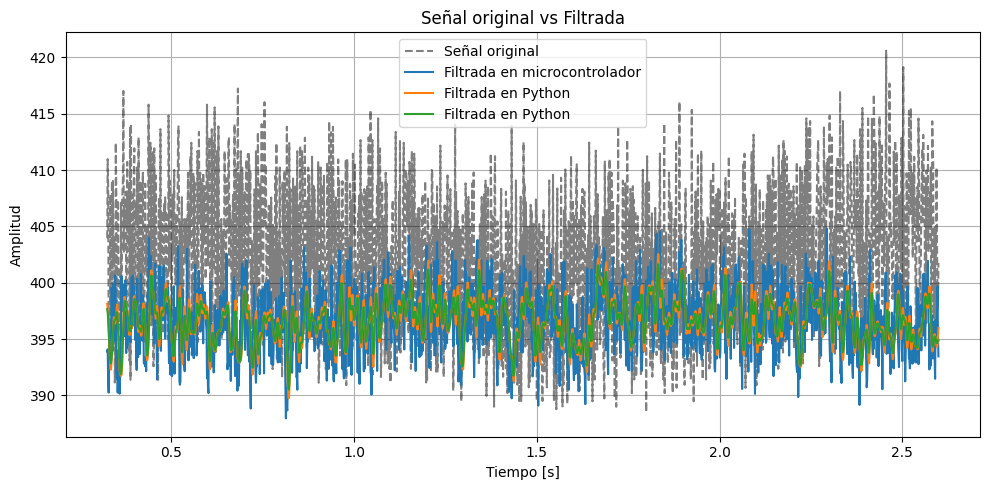

Maximo valor de la señal original: 420.6 
Minimo valor de la señal original: 388.52 
Variacion: 32.08000000000004
Maximo valor de la señal en microcontrolador: 405.05 
Minimo valor de la señal en microcontrolador: 387.97 
Variacion: 17.079999999999984 
Maximo valor de la señal filtrada FIR: 402.5561701485824 
Minimo valor de la señal filtrada FIR: 389.7501020471788 
Variacion: 12.806068101403582 
Maximo valor de la señal filtrada media movil: 401.6539615294924 
Minimo valor de la señal filtrada media movil: 390.525423104894 
Variacion: 11.12853842459839 


In [6]:
plt.figure(figsize=(10, 5))
plt.plot(t[250:], raw_samples[250:], 'k--', alpha=0.5, label='Señal original')
plt.plot(t[250:], filtered_samples[250:], label='Filtrada en microcontrolador')
plt.plot(t[250:], python_filtered[250:], label='Filtrada en Python')
plt.plot(t[250:], python_filtered_moving_avg[250:], label='Filtrada en Python')
plt.title('Señal original vs Filtrada')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

print("===============================")
print(f"Maximo valor de la señal original: {raw_samples.max()} ")
print(f"Minimo valor de la señal original: {raw_samples.min()} ")
print(f"Variacion: {raw_samples.max()-raw_samples.min()}")

print("===============================")
print(f"Maximo valor de la señal en microcontrolador: {filtered_samples.max()} ")
print(f"Minimo valor de la señal en microcontrolador: {filtered_samples.min()} ")
print(f"Variacion: {filtered_samples.max()-filtered_samples.min()} ")

print("===============================")
print(f"Maximo valor de la señal filtrada FIR: {python_filtered[250:].max()} ")
print(f"Minimo valor de la señal filtrada FIR: {python_filtered[250:].min()} ")
print(f"Variacion: {python_filtered[250:].max()-python_filtered[250:].min()} ")

print("===============================")
print(f"Maximo valor de la señal filtrada media movil: {python_filtered_moving_avg[250:].max()} ")
print(f"Minimo valor de la señal filtrada media movil: {python_filtered_moving_avg[250:].min()} ")
print(f"Variacion: {python_filtered_moving_avg[250:].max()-python_filtered_moving_avg[250:].min()} ")


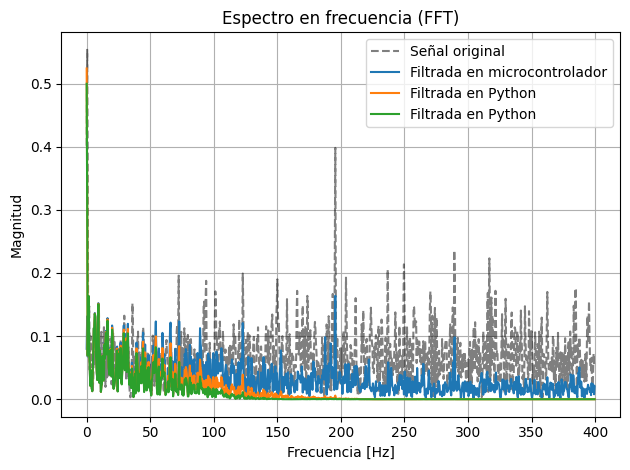

In [9]:
import numpy as np
import matplotlib.pyplot as plt


def windowed(data, window_type='hanning'):
    """
    Aplica una ventana a los datos.
    
    Parámetros:
        data (np.array): Datos a los que se les aplicará la ventana.
        window_type (str): Tipo de ventana ('hanning', 'hamming', etc.).
    
    Retorna:
        np.array: Datos con la ventana aplicada.
    """
    data = data - np.mean(data)  # eliminar componente DC
    if window_type == 'hanning':
        window = np.hanning(len(data))
    elif window_type == 'hamming':
        window = np.hamming(len(data))
    else:
        raise ValueError("Tipo de ventana no soportado.")
    
    return data * window

raw_samples_windowed = windowed(raw_samples, window_type='hanning')
filtered_samples_windowed = windowed(filtered_samples, window_type='hanning')
python_filtered_windowed = windowed(python_filtered, window_type='hanning')
python_filtered_moving_avg_windowed = windowed(python_filtered_moving_avg, window_type='hanning')

# Calcular FFT
fft_result_raw_samples = np.fft.fft(raw_samples_windowed)
freq_raw = np.fft.fftfreq(len(raw_samples), d=1/sample_rate)

# Solo parte positiva
n = len(raw_samples)

fft_magnitud = np.abs(fft_result_raw_samples[:n//2]) / n
freq_raw = freq_raw[:n//2]

fft_result_filtered_samples = np.fft.fft(filtered_samples_windowed)
fft_magnitud_filtered = np.abs(fft_result_filtered_samples[:n//2]) / n

fft_result_python_filtered = np.fft.fft(python_filtered_windowed)
fft_magnitud_python_filtered = np.abs(fft_result_python_filtered[:n//2]) / n

fft_result_python_filtered_moving_avg = np.fft.fft(python_filtered_moving_avg_windowed)
fft_magnitud_python_filtered_moving_avg = np.abs(fft_result_python_filtered_moving_avg[:n//2]) / n

# Graficar espectro
plt.plot(freq_raw, fft_magnitud, 'k--', alpha=0.5, label='Señal original')
plt.plot(freq_raw, fft_magnitud_filtered, label='Filtrada en microcontrolador')
plt.plot(freq_raw, fft_magnitud_python_filtered, label='Filtrada en Python')
plt.plot(freq_raw, fft_magnitud_python_filtered_moving_avg, label='Filtrada en Python')
plt.title("Espectro en frecuencia (FFT)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
